<a href="https://colab.research.google.com/github/avneetahuja/research-papers-implementation/blob/main/VAE_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [61]:
class VAE_Encoder_Decoder_ReParam_With_Loss(nn.Module):

  def __init__(self, in_features, h1, h2, h3, latent_size):
    super(VAE_Encoder_Decoder_ReParam_With_Loss, self).__init__()
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.fc_mu = nn.Linear(h3, latent_size)  # Layer for mean
    self.fc_logvar = nn.Linear(h3, latent_size)  # Layer for log-variance
    self.fc4 = nn.Linear(latent_size, h3)
    self.fc5 = nn.Linear(h3, h2)
    self.fc6 = nn.Linear(h2, h1)
    self.out = nn.Linear(h1, in_features)

  def reparameterizer(self,mu,logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def loss_function(self,x, reconstructed, mu, logvar):
    MSE = F.mse_loss(reconstructed, x, reduction='sum')
    # BCE = F.binary_cross_entropy(reconstructed, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))

    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    z = self.reparameterizer(mu,logvar)

    x = F.relu(self.fc4(z))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = torch.sigmoid(self.out(x))
    return x, mu, logvar

In [62]:
IMG_WIDTH = 20
IMG_HEIGHT = 28
IMG_CHANNELS = 1

In [63]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
import scipy.io
import torch

# Define image dimensions
IMG_HEIGHT, IMG_WIDTH = 28, 20

# Load and preprocess the Frey Face dataset
ff = scipy.io.loadmat('frey_rawface.mat')['ff'].astype('float32')
ff = ff.T  # Transpose to get [num_samples, 560]
ff = ff / 255.0  # Normalize to range [0, 1]
ff = torch.from_numpy(ff)  # Convert to a PyTorch tensor
ff = ff.reshape(-1, 1, IMG_HEIGHT, IMG_WIDTH)  # Reshape to [num_samples, 1, 28, 20]

# Create DataLoader for training
dataset = TensorDataset(ff)
train_ff = DataLoader(dataset, batch_size=64, shuffle=True)


In [64]:
for data in train_ff:
    print(data[0].shape)
    break

torch.Size([64, 1, 28, 20])


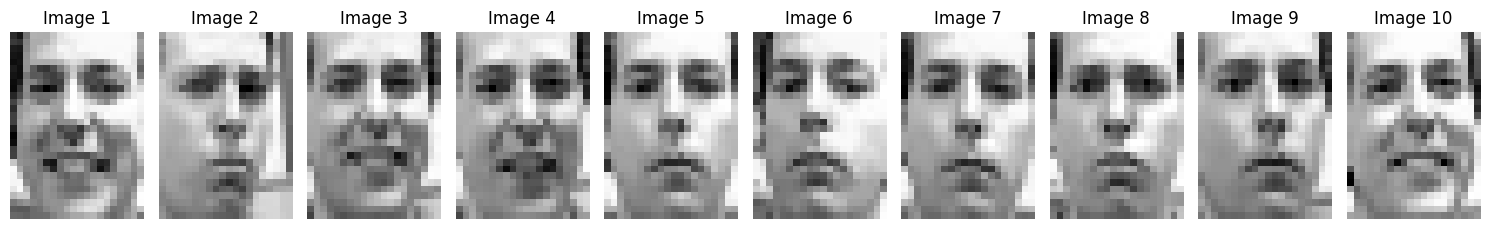

In [65]:
import matplotlib.pyplot as plt

images, = next(iter(train_ff))

num_images = 10
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i in range(num_images):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()


In [66]:
import torch.optim as optim
model = VAE_Encoder_Decoder_ReParam_With_Loss(IMG_HEIGHT*IMG_WIDTH, 512, 256, 128, 32)
num_epochs = 100
optimizer = optim.Adam(model.parameters(),lr=0.001)
for epoch in range(num_epochs):
  train_loss = 0
  for data in train_ff:
    data = data[0].reshape(-1,IMG_HEIGHT*IMG_WIDTH)
    reconstructed,mu,logvar = model(data)
    loss = model.loss_function(data,reconstructed,mu,logvar)
    optimizer.zero_grad()
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  print('Epoch: {} \t Training Loss: {:.6f}'.format(epoch, train_loss / len(train_ff)))

Epoch: 0 	 Training Loss: 644.910107
Epoch: 1 	 Training Loss: 427.597320
Epoch: 2 	 Training Loss: 422.115509
Epoch: 3 	 Training Loss: 420.856869
Epoch: 4 	 Training Loss: 419.271138
Epoch: 5 	 Training Loss: 419.007298
Epoch: 6 	 Training Loss: 418.464403
Epoch: 7 	 Training Loss: 416.744974
Epoch: 8 	 Training Loss: 416.470356
Epoch: 9 	 Training Loss: 416.284318
Epoch: 10 	 Training Loss: 415.510840
Epoch: 11 	 Training Loss: 415.088811
Epoch: 12 	 Training Loss: 414.180713
Epoch: 13 	 Training Loss: 414.394590
Epoch: 14 	 Training Loss: 414.713935
Epoch: 15 	 Training Loss: 414.701321
Epoch: 16 	 Training Loss: 414.689231
Epoch: 17 	 Training Loss: 413.872626
Epoch: 18 	 Training Loss: 414.239016
Epoch: 19 	 Training Loss: 414.057034
Epoch: 20 	 Training Loss: 413.996319
Epoch: 21 	 Training Loss: 414.055723
Epoch: 22 	 Training Loss: 414.095297
Epoch: 23 	 Training Loss: 413.044640
Epoch: 24 	 Training Loss: 413.105245
Epoch: 25 	 Training Loss: 413.458761
Epoch: 26 	 Training L

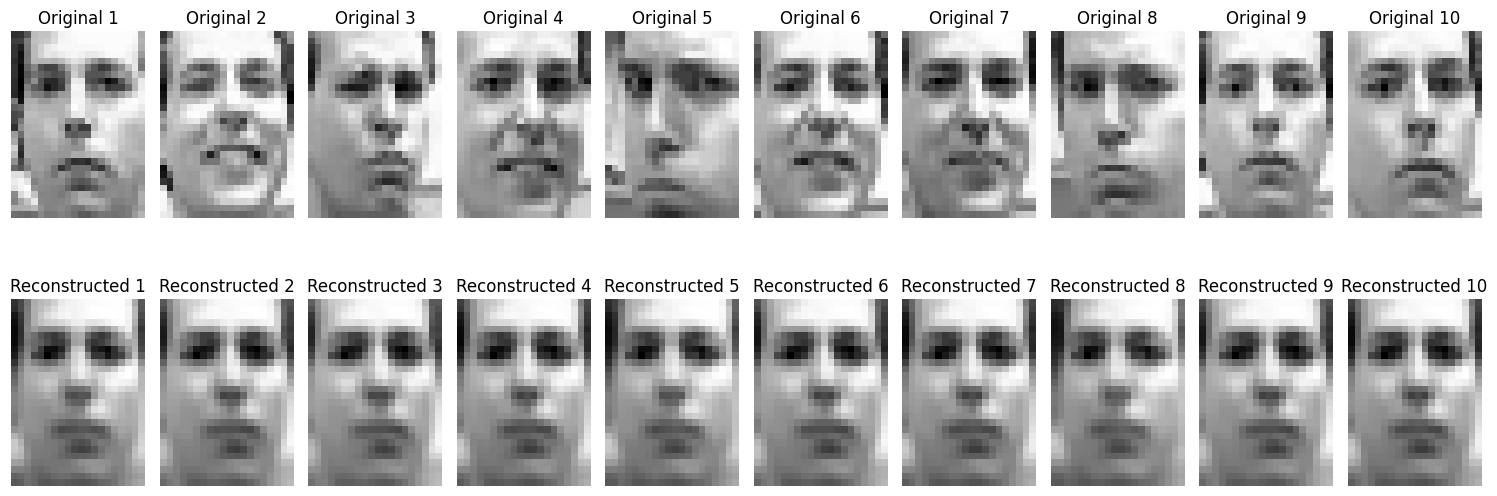

In [67]:
import matplotlib.pyplot as plt

# Load one batch of images from the DataLoader
images, = next(iter(train_ff))

# Reshape images for the model and pass them through the VAE
images_flat = images.reshape(-1, IMG_HEIGHT * IMG_WIDTH)
reconstructed_images, mu, logvar = model(images_flat)

# Choose the number of images to display
num_images = 10
fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

# Plot the images
for i in range(num_images):
    # Original images (top row)
    axes[0, i].imshow(images[i].squeeze(), cmap='gray')  # Original image
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original {i+1}")

    # Reconstructed images (bottom row)
    axes[1, i].imshow(
        reconstructed_images[i].detach().numpy().reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray'
    )  # Reconstructed image
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Reconstructed {i+1}")

plt.tight_layout()
plt.show()


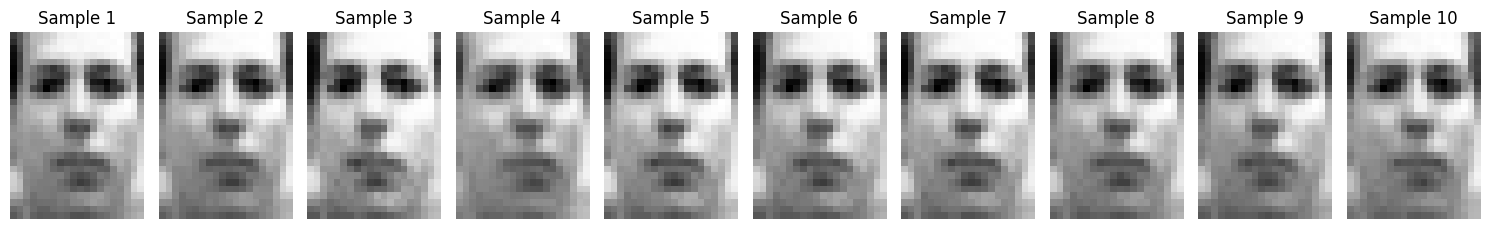

In [69]:
# Generation code provided by gpt:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Number of new images to generate
num_samples = 10

# Latent dimension (should match the `latent_size` used in your model)
latent_dim = 32

# Generate random latent vectors z from a standard normal distribution
z = torch.randn(num_samples, latent_dim)

# Pass the latent vectors through the decoder to generate images
with torch.no_grad():  # No gradients needed during inference
    generated = model.fc4(z)  # Start decoding from the latent layer
    generated = F.relu(model.fc5(generated))
    generated = F.relu(model.fc6(generated))
    generated = torch.sigmoid(model.out(generated))  # Ensure outputs are in [0, 1]

# Reshape generated images to their original dimensions (e.g., 28x28)
generated_images = generated.view(num_samples, 1, 28, 20)

# Plot the generated images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    axes[i].imshow(generated_images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Sample {i+1}")

plt.tight_layout()
plt.show()
